# Libraries

In [8]:
from datetime import date, datetime, timedelta
from zoneinfo import ZoneInfo
import io
import requests
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Daily load forecast inputs and prediction

In [9]:
# ---NTMM: Pin -> mean power & energy Today---
ymd = dt.date.today().strftime("%Y-%m-%d")
url = f"https://ntmm.org/pqlog/data/{ymd}.txt"
r = requests.get(url, timeout=20); r.raise_for_status()
df = pd.read_csv(io.StringIO(r.text), sep=r"\s+", header=None, engine="python")

P = pd.to_numeric(df.iloc[:, 7], errors="coerce").fillna(0) # Pin [W]
avg_power_today_W = float(P.mean())
energy_today_kWh  = float(P.sum() * 10 / 3600 / 1000)  

print(f"[{ymd}] avg Pin today: {avg_power_today_W:.1f} W")
print(f"[{ymd}] energy today (check): {energy_today_kWh:.3f} kWh")

# ---Open-Meteo: Mean temperature today & tomorrow---
def get_avg_temps(lat=59.3293, lon=18.0686):
    today = dt.date.today()
    tomorrow = today + dt.timedelta(days=1)
    url = (f"https://api.open-meteo.com/v1/forecast"
           f"?latitude={lat}&longitude={lon}"
           f"&hourly=temperature_2m&timezone=Europe/Stockholm")
    r = requests.get(url, timeout=10); r.raise_for_status()
    data = r.json()
    temps = np.array(data["hourly"]["temperature_2m"])
    times = [dt.datetime.fromisoformat(t) for t in data["hourly"]["time"]]
    T_today = float(np.mean([temps[i] for i, t in enumerate(times) if t.date()==today]))
    T_tom   = float(np.mean([temps[i] for i, t in enumerate(times) if t.date()==tomorrow]))
    return T_today, T_tom

T_today, T_tom = get_avg_temps()
print(f"T_today: {T_today:.1f} °C,  T_tom: {T_tom:.1f} °C")

# ---Load day-model & create X with the right columns---
day_model = joblib.load("/Users/iraklisbournazos/Desktop/Nathaniel Taylor project/Hadrien scripts/days_prediction.joblib") 

cols = ["power_active_import_avg_current_day",
        "Temperature_avg_current_day",
        "temperature_avg_1d_future"]

X_day = pd.DataFrame([[avg_power_today_W, T_today, T_tom]], columns=cols)

# ---Forecasting for tomorrow---
y_pred_avg_W = float(day_model.predict(X_day)[0])  # mean power for tomorrow in (W)
y_pred_energy_kWh = y_pred_avg_W * 24 / 1000 # try to calculate the energy for tomorrow in kWh/day

print(f"Predicted avg Pin tomorrow: {y_pred_avg_W:.1f} W")
print(f"Predicted energy tomorrow:  {y_pred_energy_kWh:.2f} kWh")


[2025-12-15] avg Pin today: 2868.7 W
[2025-12-15] energy today (check): 48.911 kWh
T_today: 8.2 °C,  T_tom: 6.6 °C
Predicted avg Pin tomorrow: 3179.4 W
Predicted energy tomorrow:  76.30 kWh


/var/folders/cj/hstcg8jj049d692w5pbvkbs00000gn/T/ipykernel_10309/2824214805.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred_avg_W = float(day_model.predict(X_day)[0])  # mean power for tomorrow in (W)


# Real-time inputs and next 24h power forecast

In [10]:
TZ = ZoneInfo("Europe/Stockholm")
LAT, LON = 59.3293, 18.0686
HOURS_MODEL_PATH = "/Users/iraklisbournazos/Desktop/Nathaniel Taylor project/Hadrien scripts/hours_prediction.joblib"
y_pred_avg_W = float(y_pred_avg_W) 

# ---NTMM TXT -> current-hour mean power---
def fetch_ntmm_txt_df(ymd: str) -> pd.DataFrame:
    url = f"https://ntmm.org/pqlog/data/{ymd}.txt"
    r = requests.get(url, timeout=20); r.raise_for_status()
    df = pd.read_csv(io.StringIO(r.text), sep=r"\s+", header=None, engine="python")
    #  DatetimeIndex with first 6 columns (Y M D h m s)
    parts = df.iloc[:, :6].astype(int)
    dt_index = pd.to_datetime(
        dict(year=parts[0], month=parts[1], day=parts[2],
             hour=parts[3], minute=parts[4], second=parts[5]),
        utc=False
    ).dt.tz_localize(TZ, nonexistent="shift_forward", ambiguous="NaT")
    df.index = dt_index
    return df

def get_current_hour_avg_power_W(df: pd.DataFrame) -> float:
    P = pd.to_numeric(df.iloc[:, 7], errors="coerce")
    # Hourly
    hourly = P.resample("1h").mean()
    now = dt.datetime.now(TZ).replace(minute=0, second=0, microsecond=0)
    last_full_hour = now - dt.timedelta(hours=1)
    if last_full_hour in hourly.index:
        return float(hourly.loc[last_full_hour])
    # 
    if len(hourly) >= 2:
        return float(hourly.iloc[-2])
    return float(hourly.iloc[-1])

today = dt.date.today().strftime("%Y-%m-%d")
df_txt = fetch_ntmm_txt_df(today)
power_active_import_avg_current_hour = get_current_hour_avg_power_W(df_txt)

# ----Open-Meteo temps: current-hour + next 24h---
def get_hourly_temps(lat: float, lon: float, tz: ZoneInfo) -> pd.DataFrame:
    url = (
        "https://api.open-meteo.com/v1/forecast"
        f"?latitude={lat}&longitude={lon}"
        "&hourly=temperature_2m"
        "&timezone=Europe%2FStockholm"
    )
    r = requests.get(url, timeout=20); r.raise_for_status()
    js = r.json()
    times = pd.to_datetime(js["hourly"]["time"]).tz_localize(tz)
    temps = pd.Series(js["hourly"]["temperature_2m"], index=times, name="temperature_2m")
    return temps.to_frame()

temps_df = get_hourly_temps(LAT, LON, TZ)

now_hour = dt.datetime.now(TZ).replace(minute=0, second=0, microsecond=0)
Temperature_avg_current_hour = float(temps_df.reindex([now_hour]).iloc[0, 0])

# Next 24 hours
future_hours_index = [now_hour + dt.timedelta(hours=h) for h in range(1, 25)]
temps_next_24 = temps_df.reindex(future_hours_index)["temperature_2m"].astype(float).tolist()

# ---Build features for hours model ---
feat = {
    "power_active_import_avg_1d_future_pred": float(y_pred_avg_W),
    "power_active_import_avg_current_hour":   float(power_active_import_avg_current_hour),
    "Temperature_avg_current_hour":           float(Temperature_avg_current_hour),
}
for h in range(1, 25):
    feat[f"temperature_avg_{h}h_future"] = float(temps_next_24[h-1])

X_hours = pd.DataFrame([feat])

hours_model = joblib.load(HOURS_MODEL_PATH)
needed_cols = list(getattr(hours_model, "feature_names_in_", X_hours.columns))
X_hours = X_hours.reindex(columns=needed_cols)

# ---Predict next-24h power (W) ---
y_hours_W = hours_model.predict(X_hours).ravel()  
pred_index = pd.Index(future_hours_index, name="timestamp")
forecast_24h = pd.Series(y_hours_W, index=pred_index, name="Pin_pred_W")

print("current-hour avg power (W):", round(power_active_import_avg_current_hour))
print("current-hour temperature (°C):", round(Temperature_avg_current_hour, 1))
print("day-model avg power tomorrow (W):", round(y_pred_avg_W))

print("\n=== Next 24h forecast (W) ===")
for ts, val in forecast_24h.items():
    print(ts.strftime("%Y-%m-%d %H:%M"), f"{round(float(val))} W")


current-hour avg power (W): 3113
current-hour temperature (°C): 8.1
day-model avg power tomorrow (W): 3179

=== Next 24h forecast (W) ===
2025-12-15 18:00 3521 W
2025-12-15 19:00 3638 W
2025-12-15 20:00 3358 W
2025-12-15 21:00 3921 W
2025-12-15 22:00 3448 W
2025-12-15 23:00 4410 W
2025-12-16 00:00 4591 W
2025-12-16 01:00 4297 W
2025-12-16 02:00 3442 W
2025-12-16 03:00 3293 W
2025-12-16 04:00 3039 W
2025-12-16 05:00 3094 W
2025-12-16 06:00 3468 W
2025-12-16 07:00 3439 W
2025-12-16 08:00 3313 W
2025-12-16 09:00 3518 W
2025-12-16 10:00 3725 W
2025-12-16 11:00 3866 W
2025-12-16 12:00 4986 W
2025-12-16 13:00 5049 W
2025-12-16 14:00 3952 W
2025-12-16 15:00 3548 W
2025-12-16 16:00 4187 W
2025-12-16 17:00 3171 W


# Results

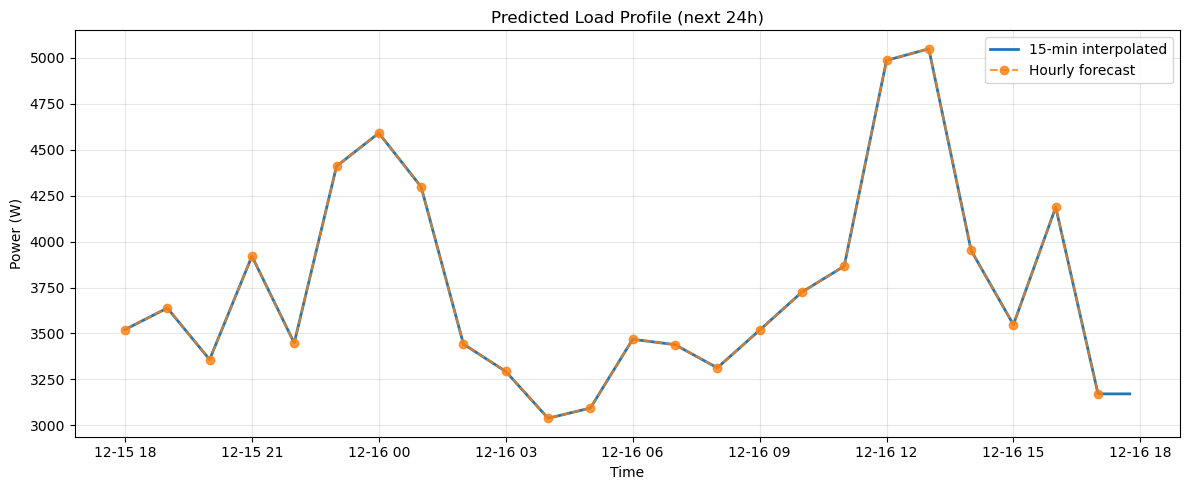

Forecast energy next 24h: 90.14 kWh


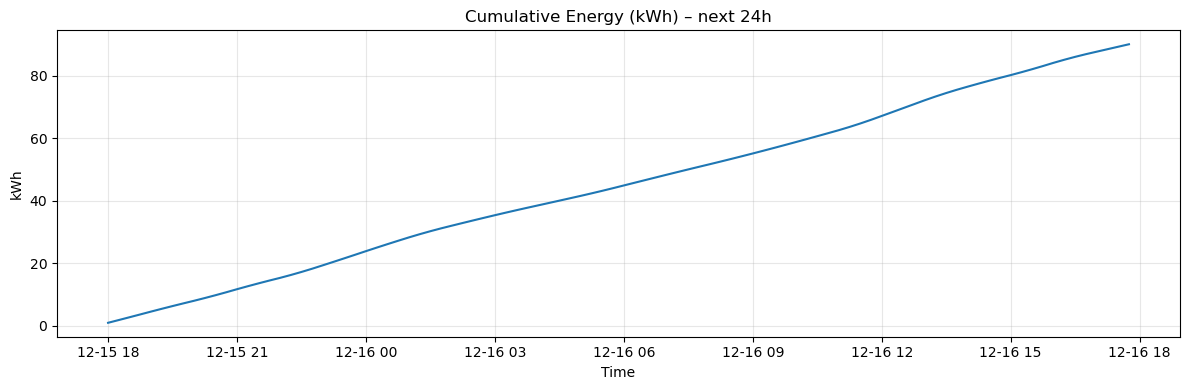

In [11]:
# 15-min interpolation
new_index = pd.date_range(start=forecast_24h.index[0], periods=96, freq="15min")

forecast_15min = forecast_24h.reindex(new_index).interpolate("linear")

# save to CSV 
forecast_15min_df = forecast_15min.reset_index()
forecast_15min_df.columns = ["timestamp", "predicted_power_W"]
forecast_15min_df.to_csv("forecast_15min_load.csv", index=False)

# ---Plot---
plt.figure(figsize=(12, 5))
plt.plot(forecast_15min.index, forecast_15min.values, label="15-min interpolated", linewidth=2)
plt.plot(forecast_24h.index, forecast_24h.values, "o--", label="Hourly forecast", alpha=0.8)
plt.title("Predicted Load Profile (next 24h)")
plt.xlabel("Time")
plt.ylabel("Power (W)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ---Cumulative energy over next 24h---
energy_15min_kWh = (forecast_15min * 0.25 / 1000.0)   # W * h / 1000 -> kWh
cum_energy_kWh = energy_15min_kWh.cumsum()

print(f"Forecast energy next 24h: {energy_15min_kWh.sum():.2f} kWh")

plt.figure(figsize=(12, 4))
plt.plot(cum_energy_kWh.index, cum_energy_kWh.values)
plt.title("Cumulative Energy (kWh) – next 24h")
plt.xlabel("Time")
plt.ylabel("kWh")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Predicted load of the next day saved in a new csv file

In [12]:
df_load = forecast_15min.rename("Pin_pred_W").reset_index()
df_load.columns = ["Time", "Pin_pred_W"] 

# Save with Time column
df_load.to_csv("predicted_load_24h.csv", index=False)
print("Saved predicted_load_24h.csv with Time + Pin_pred_W")


Saved predicted_load_24h.csv with Time + Pin_pred_W
